In [ ]:
#importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize
from skopt import gp_minimize
from skopt.space import Real

sns.set(style="whitegrid", context="talk", palette="deep")



Libraries imported successfully!


In [ ]:

from google.colab import files

# Upload your cleaned CSV file (e.g., historical_prices_cleaned.csv)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load price data and parse dates
prices = pd.read_csv(filename, index_col=0, parse_dates=True)
print("Price Data (first 5 rows):")
print(prices.head())

def compute_returns(prices): #Computes weekly returns from price data.

    returns = prices.pct_change(fill_method=None).dropna()
    return returns

returns = compute_returns(prices)
print("Weekly Returns (first 5 rows):")
print(returns.head())


Saving historical_prices_cleaned.csv to historical_prices_cleaned.csv
Price Data (first 5 rows):
              AMZN         GE      GOOGL        HSY        MMM       MSFT  \
Date                                                                        
2012-01-01  9.1305  69.240280  16.208012  44.837509  46.040127  22.132902   
2012-01-08  8.9210  69.945709  15.583897  45.421150  46.167137  22.243130   
2012-01-15  9.5465  71.096581  14.611446  45.465488  47.299232  23.392693   
2012-01-22  9.7685  70.651070  14.461590  45.243847  48.298786  23.014755   
2012-01-29  9.3840  70.613945  14.869270  45.184734  48.447895  23.809998   

                  SHY  
Date                   
2012-01-01  71.186943  
2012-01-08  71.245903  
2012-01-15  71.229073  
2012-01-22  71.304886  
2012-01-29  71.237541  
Weekly Returns (first 5 rows):
                AMZN        GE     GOOGL       HSY       MMM      MSFT  \
Date                                                                     
2012-01-08 -0.02

In [ ]:

mean_returns = returns.mean().values
cov_matrix = returns.cov().values
assets = returns.columns.tolist()  # e.g., ["MSFT", "MMM", "HSY", "GE", "GOOGL", "AMZN", "SHY"]

print("Assets:", assets)
print("Mean Returns:", mean_returns)
print("Covariance Matrix:\n", cov_matrix)


Assets: ['AMZN', 'GE', 'GOOGL', 'HSY', 'MMM', 'MSFT', 'SHY']
Mean Returns: [0.00537618 0.0015733  0.00409927 0.00257166 0.00148001 0.00505033
 0.00015577]
Covariance Matrix:
 [[ 1.74927751e-03  4.04517479e-04  8.59872377e-04  1.27103538e-04
   3.60181369e-04  6.97895695e-04  1.46205402e-06]
 [ 4.04517479e-04  1.93058787e-03  5.22885364e-04  2.23028823e-04
   6.18470322e-04  3.88525477e-04 -8.05138190e-06]
 [ 8.59872377e-04  5.22885364e-04  1.32987492e-03  2.17542193e-04
   4.28311880e-04  7.04746724e-04  2.42181680e-07]
 [ 1.27103538e-04  2.23028823e-04  2.17542193e-04  6.95611431e-04
   2.46724738e-04  2.63524046e-04 -4.97763350e-08]
 [ 3.60181369e-04  6.18470322e-04  4.28311880e-04  2.46724738e-04
   8.82381535e-04  3.95915765e-04 -3.11998070e-06]
 [ 6.97895695e-04  3.88525477e-04  7.04746724e-04  2.63524046e-04
   3.95915765e-04  1.04924533e-03  1.12088568e-06]
 [ 1.46205402e-06 -8.05138190e-06  2.42181680e-07 -4.97763350e-08
  -3.11998070e-06  1.12088568e-06  3.08820111e-06]]


In [ ]:

def make_port(means, covariance, assets=None, max_allocation=0.5, min_allocation=0.0,
              risk_premium_up=0.5, risk_increment=0.005):

   # Constructs the efficient frontier using mean-variance optimization.
   # Returns a DataFrame with asset weights, portfolio risk, expected return, and Sharpe ratio.
    n = len(means)
    if assets is None:
        assets = [f"Asset_{i+1}" for i in range(n)]
    risk_premiums = np.arange(0, risk_premium_up + risk_increment, risk_increment)
    portfolio_list = []
    bounds = [(min_allocation, max_allocation)] * n
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

    def objective(x, rp):
        return 0.5 * np.dot(x, np.dot(covariance, x)) - np.dot(rp * means, x)

    for rp in risk_premiums:
        res = minimize(objective, np.repeat(1/n, n), args=(rp,), method='SLSQP', bounds=bounds, constraints=constraints)
        if res.success:
            w = np.round(res.x, 4)
            risk = np.sqrt(np.dot(w, np.dot(covariance, w)))
            ret = np.dot(w, means)
            sharpe = ret / risk if risk > 0 else np.nan
            portfolio_list.append(np.concatenate((w, [risk, ret, sharpe])))

    cols = assets + ["Std.Dev", "Exp.Return", "Sharpe"]
    return pd.DataFrame(portfolio_list, columns=cols)

def naive_portfolio(means, covariance, max_alloc=0.5, min_alloc=-0.5, assets=None):

   # Constructs a naive optimal portfolio by maximizing the Sharpe ratio.

    eff = make_port(means, covariance, assets=assets, max_allocation=max_alloc, min_allocation=min_alloc)
    optimal = eff.loc[eff["Sharpe"].idxmax()]
    return optimal


In [ ]:

def neg_sharpe(weights, means, cov):
    # objective: Negative Sharpe ratio for minimization
    weights = np.array(weights) / np.sum(weights)
    ret = np.dot(weights, means)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return -ret / risk

dimensions = [Real(0, 1) for _ in assets]

res = gp_minimize(lambda w: neg_sharpe(w, mean_returns, cov_matrix),
                  dimensions, n_calls=50, random_state=42)

bayesian_weights = np.array(res.x) / np.sum(res.x)

print("Bayesian Optimal Weights:", bayesian_weights)
print("Bayesian Max Sharpe Ratio:", -res.fun)


Bayesian Optimal Weights: [0.15871624 0.         0.         0.2125811  0.         0.30648953
 0.32221313]
Bayesian Max Sharpe Ratio: 0.17741372525216018


In [ ]:

# Compute naive optimal portfolio using our function
naive_opt = naive_portfolio(mean_returns, cov_matrix, max_alloc=0.5, min_alloc=-0.5, assets=assets)
print("Naive Optimal Portfolio:")
print(naive_opt)

# Create a combined results table for weights
combined_df = pd.DataFrame({
    "Asset": assets,
    "Naive Weights": naive_opt[assets].values,
    "Bayesian Weights": bayesian_weights
})
print("\nCombined Portfolio Weights Comparison:")
print(combined_df)

# Calculate Sharpe ratios for comparison
naive_sharpe = naive_opt["Sharpe"]
bayesian_sharpe = -res.fun
percentage_increase = ((bayesian_sharpe - naive_sharpe) / naive_sharpe) * 100

print(f"\nNaive Sharpe Ratio: {naive_sharpe:.4f}")
print(f"Bayesian Sharpe Ratio: {bayesian_sharpe:.4f}")
print(f"Percentage Increase in Sharpe Ratio: {percentage_increase:.2f}%")


Naive Optimal Portfolio:
AMZN          0.500000
GE           -0.163500
GOOGL         0.423000
HSY           0.496400
MMM          -0.255900
MSFT          0.500000
SHY          -0.500000
Std.Dev       0.044457
Exp.Return    0.007510
Sharpe        0.168928
Name: 81, dtype: float64

Combined Portfolio Weights Comparison:
   Asset  Naive Weights  Bayesian Weights
0   AMZN         0.5000          0.158716
1     GE        -0.1635          0.000000
2  GOOGL         0.4230          0.000000
3    HSY         0.4964          0.212581
4    MMM        -0.2559          0.000000
5   MSFT         0.5000          0.306490
6    SHY        -0.5000          0.322213

Naive Sharpe Ratio: 0.1689
Bayesian Sharpe Ratio: 0.1774
Percentage Increase in Sharpe Ratio: 5.02%


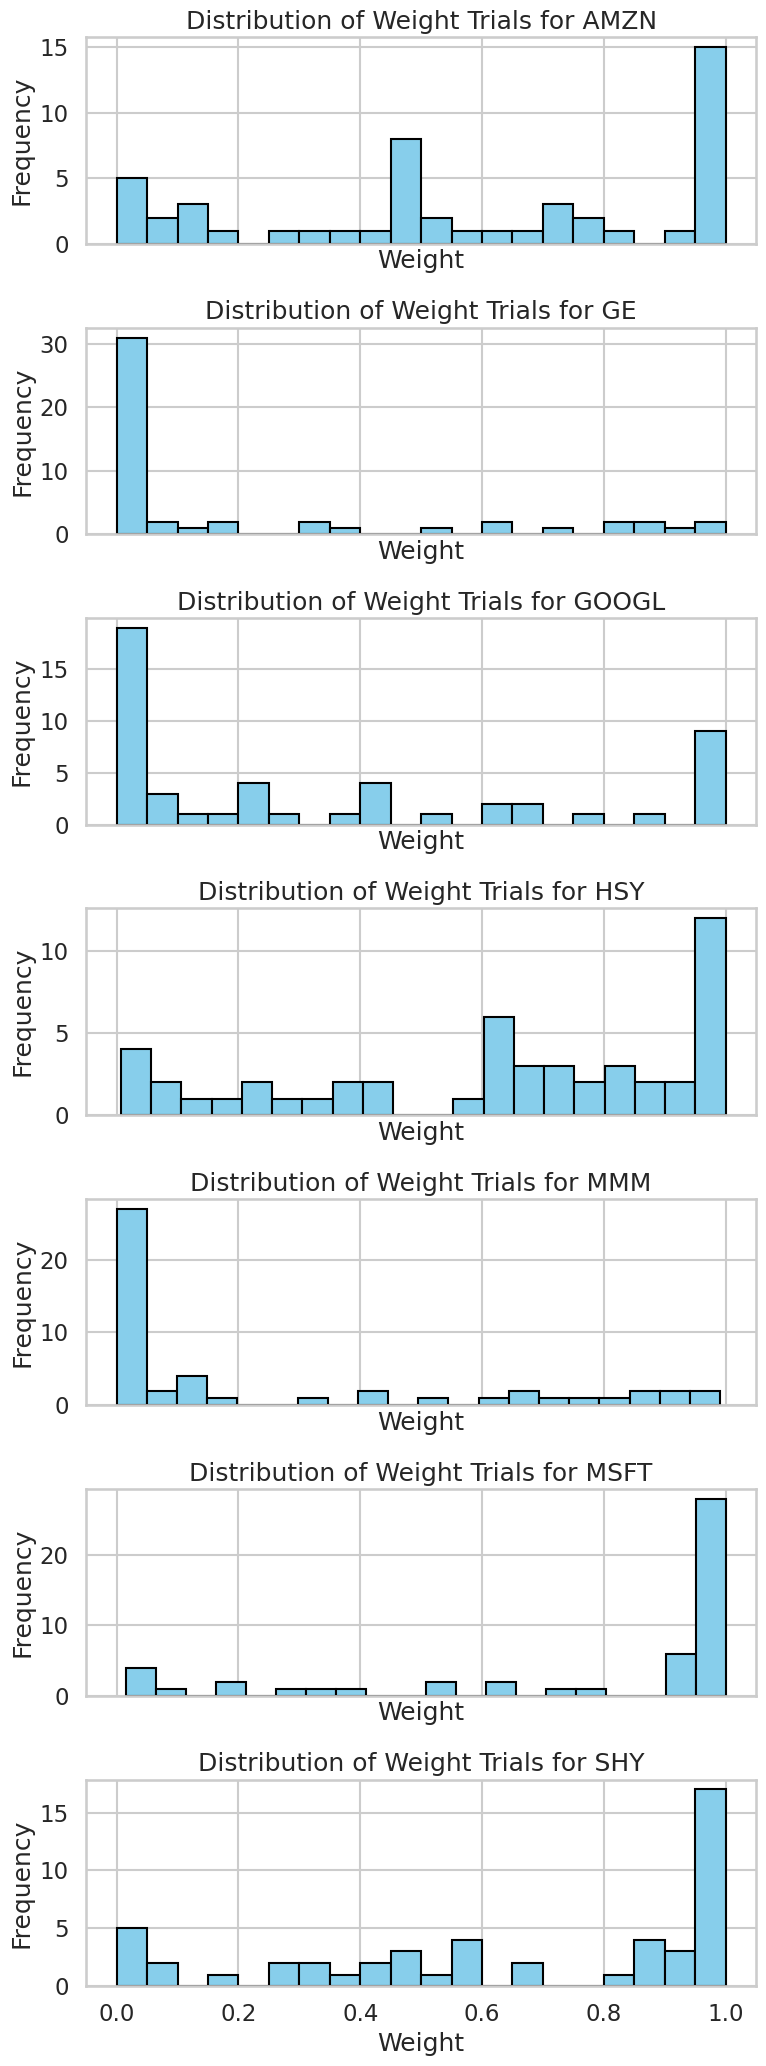

In [ ]:

import matplotlib.pyplot as plt

# Convert optimization history to a numpy array
x_iters = np.array(res.x_iters)

fig, axs = plt.subplots(len(assets), 1, figsize=(8, 3 * len(assets)), sharex=True)
for i, asset in enumerate(assets):
    axs[i].hist(x_iters[:, i], bins=20, color="skyblue", edgecolor="black")
    axs[i].set_title(f"Distribution of Weight Trials for {asset}")
    axs[i].set_xlabel("Weight")
    axs[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:

def port_performance(opt_weights, test_returns): # Computes cumulative portfolio returns given a weight vector and test returns.
                                                 # Returns a dictionary with cumulative returns, test dates, and the weight vector.

    port_ret = test_returns.dot(opt_weights)
    tret = (port_ret + 1).cumprod().values
    return {"tret": tret, "tlab": test_returns.index, "weights": opt_weights}

def port_summary_updated(test_returns, weights):
    port_ret = test_returns.dot(weights)
    ann_return = 52 * np.mean(port_ret)
    ann_risk = np.sqrt(52) * np.std(port_ret)
    sharpe_ratio = ann_return / ann_risk if ann_risk > 0 else np.nan
    return ann_return, ann_risk, sharpe_ratio

# Evaluate performance for both portfolios
naive_perf = port_performance(naive_opt[assets].values, returns)
naive_summary = port_summary_updated(returns, naive_opt[assets].values)
bayesian_perf = port_performance(bayesian_weights, returns)
bayesian_summary = port_summary_updated(returns, bayesian_weights)

print("Naive Portfolio Performance (Annualized):")
print(f"Return: {naive_summary[0]:.4f}, Risk: {naive_summary[1]:.4f}, Sharpe: {naive_summary[2]:.4f}")
print("\nBayesian Portfolio Performance (Annualized):")
print(f"Return: {bayesian_summary[0]:.4f}, Risk: {bayesian_summary[1]:.4f}, Sharpe: {bayesian_summary[2]:.4f}")


Naive Portfolio Performance (Annualized):
Return: 0.3905, Risk: 0.3203, Sharpe: 1.2191

Bayesian Portfolio Performance (Annualized):
Return: 0.1559, Risk: 0.1218, Sharpe: 1.2804


In [ ]:

import plotly.express as px

# Prepare DataFrames for cumulative returns
naive_cum_df = pd.DataFrame({
    "Date": returns.index,
    "Cumulative Return": naive_perf["tret"]
})

bayesian_cum_df = pd.DataFrame({
    "Date": returns.index,
    "Cumulative Return": bayesian_perf["tret"]
})
fig_naive = px.line(naive_cum_df, x="Date", y="Cumulative Return",
                    title="Interactive Cumulative Returns - Naive Portfolio",
                    labels={"Cumulative Return": "Naive Cumulative Return"})
fig_naive.update_layout(title_font_size=24, xaxis_title="Date", yaxis_title="Naive Cumulative Return")
fig_naive.show()

fig_bayes = px.line(bayesian_cum_df, x="Date", y="Cumulative Return",
                    title="Interactive Cumulative Returns - Bayesian Portfolio",
                    labels={"Cumulative Return": "Bayesian Cumulative Return"})
fig_bayes.update_layout(title_font_size=24, xaxis_title="Date", yaxis_title="Bayesian Cumulative Return")
fig_bayes.show()

